# Influenza Prediction in Ireland
- side project

In [2]:
# import libraries
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import time as time
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.learning_curve import validation_curve

from functools import reduce
# just for sanity
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None) 
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)

# Prologue
- i have taken the liberty of pre-processing and amalgamting the original datasets into 'influenza_cases_ireland.csv'
- the features with ILI-Denominator- refers to the actual population size, ILI without the -Denominator is the actual cases of influenza, the numbers denote the age range e.g 00-04 for population less than 4 years. ILINumberOfCases is the total occurence for the week, and is our dependent variable in this notebook.
- MaxTemp, MinTemp and AvgPrec are computed by taking daily and weekly averages of observations. 
- AvgPrec stands for precipitation
- the data runs from 2006 to 2015.

## Hypothesis
- we begin the analysis with prior knowledge that influenza cases are correlated with climatic conditions e.g temperature, precipitation, humidity.
- since, we only data for temperature and preicipitation, we ask:
- Is Influenza Cases in Ireland correlated with the temperature and/or preicipitation?
- If yes, which plays a bigger role? 

In [3]:
df = pd.read_csv('influenza_cases_ireland.csv')

In [4]:
df.head()

,Country,Year,WeekOfYear,WeekStartDate,ILI_Denominator00-04,ILI_Denominator05-14,ILI_Denominator15-64,ILI_Denominator65+,ILI_DenominatorNumberOfCases,ILI00-04,ILI05-14,ILI15-64,ILI65+,ILINumberOfCases,MaxTemp,MinTemp,AvgPrec
0,Ireland,2006,1,2006-01-02,10192,20183,97393,15999,143767,0,0,11,3,14,77.102041,30.346939,20.163265
1,Ireland,2006,2,2006-01-09,9880,19565,94412,15510,139367,1,1,13,0,15,103.979592,35.877551,45.285714
2,Ireland,2006,3,2006-01-16,9997,19798,95537,15694,141026,3,2,18,2,25,98.163265,50.081633,24.836735
3,Ireland,2006,4,2006-01-23,9887,19579,94480,15521,139467,2,2,18,1,23,76.857143,28.326531,5.714286
4,Ireland,2006,5,2006-01-30,10312,20421,98545,16189,145467,0,4,18,2,24,81.448980,25.836735,7.408163


# EDA
- We show the relationship between the MaxTemp,MinTemo and AvgPrec.
- Comparing the first and second plot, it is obvious that temp has a higher correlation with influenza cases than precipitation.
- this also shows that temperature and week of year are highly correlated.
- notice the sharp differences between other years and 2009, 2010 and 2011. this would explain some observations in later developments.

### - Plot of Week of Year v. Cases, Max/Min Temp

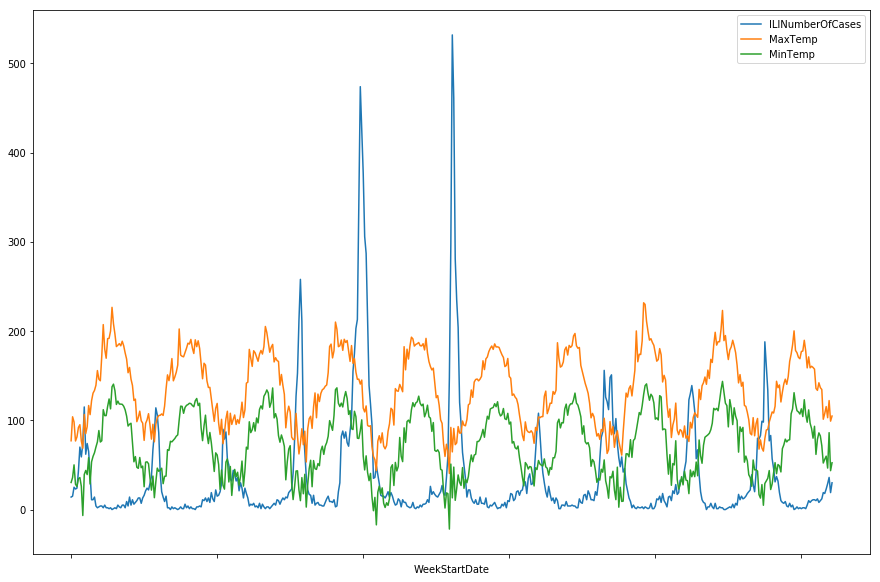

In [5]:
df.plot(x="WeekStartDate", y=["ILINumberOfCases","MaxTemp","MinTemp"])
plt.show()

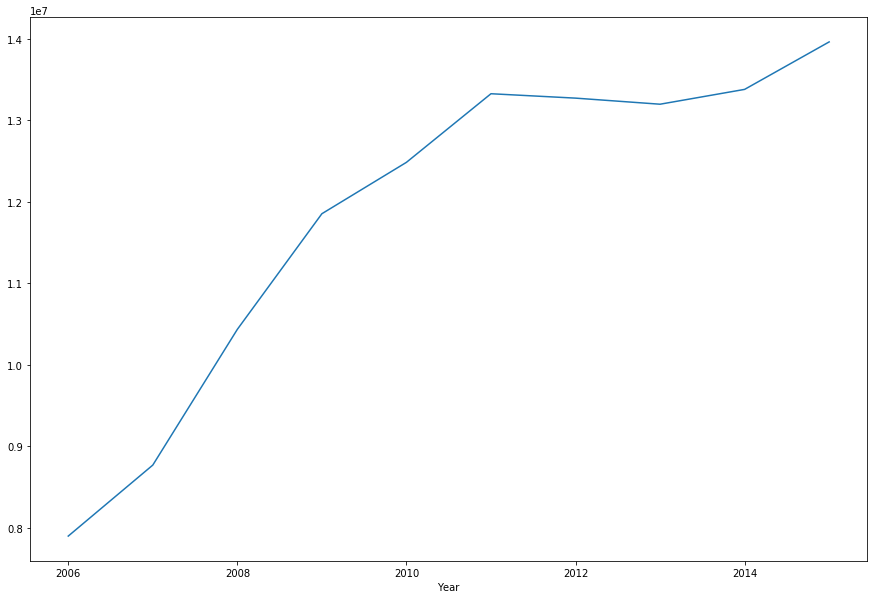

In [35]:
df.groupby(['Year']).sum()['ILI_DenominatorNumberOfCases'].plot()

### - Plot of Week of Year v. Cases, Population Sample, Min Temp


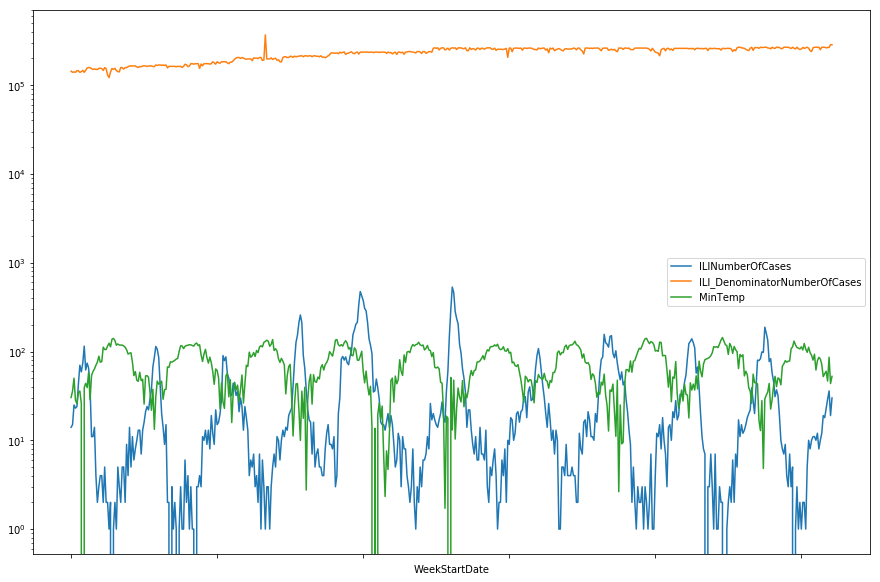

In [13]:
df.plot(x="WeekStartDate", y=["ILINumberOfCases","ILI_DenominatorNumberOfCases","MinTemp"],logy=True)
plt.show()

### - Plot of Week of Year v. Cases, Precipitation

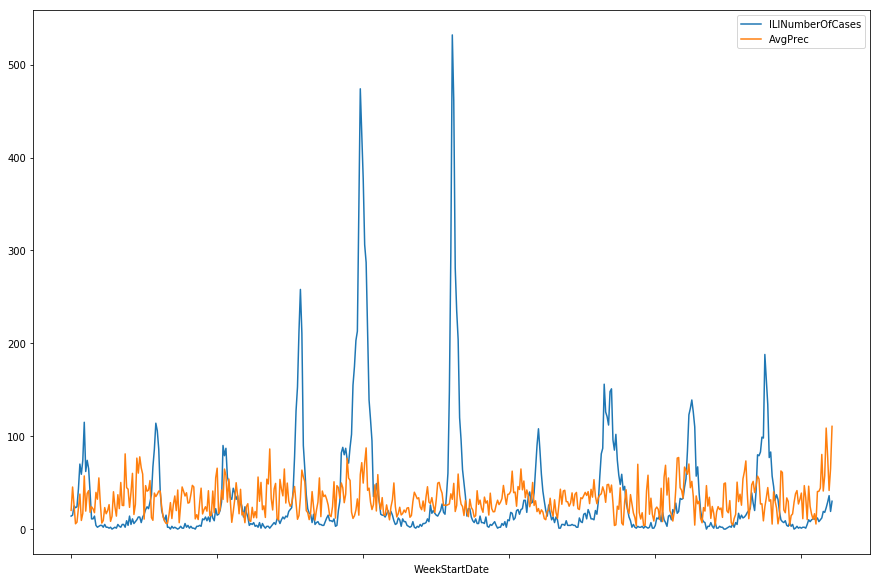

In [13]:
df.plot(x="WeekStartDate", y=["ILINumberOfCases","AvgPrec"])
plt.show()

### - Plot of Week of Year v. Cases, Population sample for the different age groups

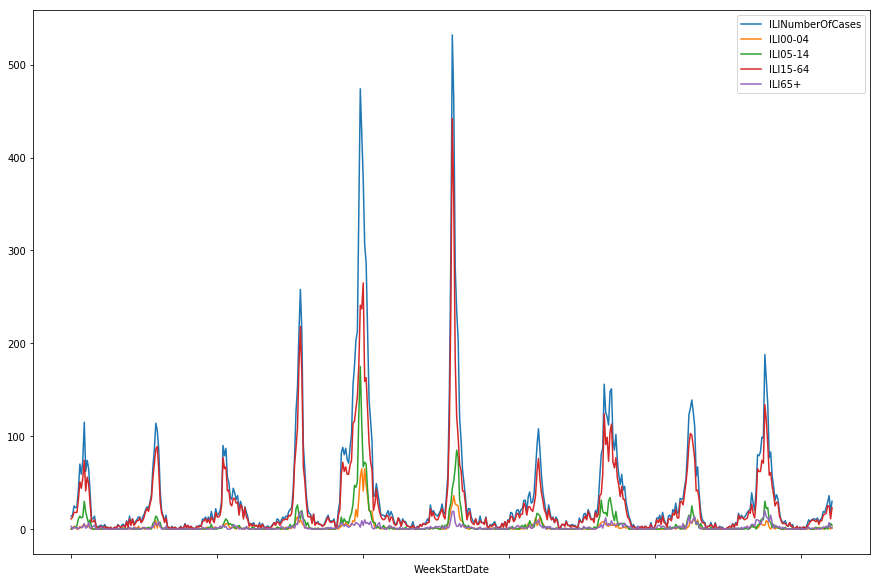

In [14]:
df.plot(x="WeekStartDate", y=["ILINumberOfCases","ILI00-04","ILI05-14","ILI15-64","ILI65+"])
plt.show()

- the correlation plot confirms claim that temperature is highly correlated to influenza cases than precipitation. 

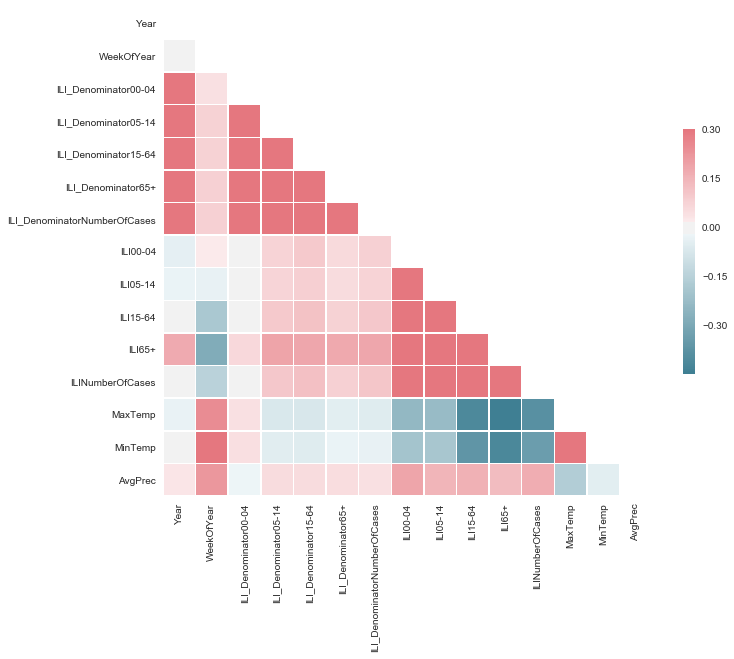

In [15]:
sns.set(style="white")
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Plot Cases by Week for each Year
- the trend shows an obvious plunge after the 20th week.
- two models for the different times of the year?

In [19]:
year_2006 = df.loc[df['Year'] == 2006]
year_2007 = df.loc[df['Year'] == 2007]
year_2008 = df.loc[df['Year'] == 2008]
year_2009 = df.loc[df['Year'] == 2009]
year_2010 = df.loc[df['Year'] == 2010]
year_2011 = df.loc[df['Year'] == 2011]
year_2012 = df.loc[df['Year'] == 2012]
year_2013 = df.loc[df['Year'] == 2013]
year_2014 = df.loc[df['Year'] == 2014]
year_2015 = df.loc[df['Year'] == 2015]

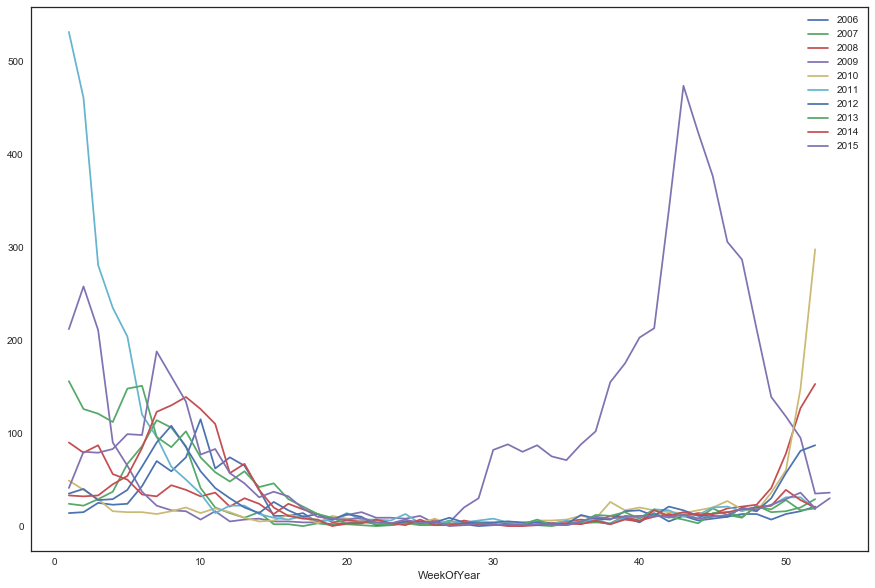

In [20]:
ax = year_2006.plot(x='WeekOfYear', y='ILINumberOfCases',label='2006')
year_2007.plot(ax=ax, x='WeekOfYear', y='ILINumberOfCases',label='2007')
year_2008.plot(ax=ax, x='WeekOfYear', y='ILINumberOfCases',label='2008')
year_2009.plot(ax=ax, x='WeekOfYear', y='ILINumberOfCases',label='2009')
year_2010.plot(ax=ax, x='WeekOfYear', y='ILINumberOfCases',label='2010')
year_2011.plot(ax=ax, x='WeekOfYear', y='ILINumberOfCases',label='2011')
year_2012.plot(ax=ax, x='WeekOfYear', y='ILINumberOfCases',label='2012')
year_2013.plot(ax=ax, x='WeekOfYear', y='ILINumberOfCases',label='2013')
year_2014.plot(ax=ax, x='WeekOfYear', y='ILINumberOfCases',label='2014')
year_2015.plot(ax=ax, x='WeekOfYear', y='ILINumberOfCases',label='2015')

# Predictions
- we remove population sample as an independent variable, it can be argued that this may provide additional information but i posit that this would be more insightful if the problem was to predict cases for each of the age groups. In which case, we will need to use the population samples for each group.
- using 'Year' as a predictor produced slightly better accuracies for each of the models, explainable because it leaks information. notice in the EDA plots where 2009 - 2011 had much higher cases than other years. 

In [22]:
# predictors = ['WeekOfYear','ILI_DenominatorNumberOfCases','MaxTemp','AvgPrec','MinTemp']
predictors = ['WeekOfYear','MaxTemp','AvgPrec','MinTemp']

## - Linear Regression

In [23]:
trainSet,testSet = train_test_split(df,test_size = 0.2,shuffle=False)
# testSet
X_test = testSet[predictors]
Y_test = testSet['ILINumberOfCases']
# trainSet
X_train = trainSet[predictors]
Y_train = trainSet['ILINumberOfCases']

lm = LinearRegression()
scores = cross_val_score(lm, X_train, Y_train, cv = 5)   
# print (scores, np.mean(scores), np.std(scores))
# predictions = cross_val_predict(lm, X_test, Y_test, cv = 5)  

lm.fit(X_train, Y_train)
y_hat = lm.predict(X_test) 
linReg_mae = mean_absolute_error(Y_test, y_hat)   

In [24]:
print(linReg_mae)

26.22209360931065


In [25]:
# # Two Models - Linear Regression
model_1 = df[(df['WeekOfYear'] <= 1) | (df['WeekOfYear'] <= 20)]
model_2 = df[(df['WeekOfYear'] > 20) & (df['WeekOfYear'] <= 52)]

# df.fillna(method='bfill', inplace=True)
trainingSet_1, testSet_1 = train_test_split(model_1, test_size=0.2,shuffle = False)
trainingSet_2, testSet_2 = train_test_split(model_2, test_size=0.2,shuffle = False)

# testSet
X_test_1 = testSet_1[predictors]
X_test_2 = testSet_2[predictors]
Y_test_1 = testSet_1['ILINumberOfCases']
Y_test_2 = testSet_2['ILINumberOfCases']

# trainSet
X_train_1 = trainingSet_1[predictors]
X_train_2 = trainingSet_2[predictors]
Y_train_1 = trainingSet_1['ILINumberOfCases']
Y_train_2 = trainingSet_2['ILINumberOfCases']


# Model 1
lm1 = LinearRegression()
scores = cross_val_score(lm1, X_train_1, Y_train_1, cv = 5)   
lm1.fit(X_train_1, Y_train_1)
y_hat_1 = lm1.predict(X_test_1) 
# linReg_mae_1 = mean_absolute_error(Y_test_1, y_hat_1)  

# Model 2
lm2 = LinearRegression()
scores2 = cross_val_score(lm2, X_train_2, Y_train_2, cv = 5)   
lm2.fit(X_train_2, Y_train_2)
y_hat_2 = lm2.predict(X_test_2) 
# linReg_mae_2 = mean_absolute_error(Y_test_2, y_hat_2)  

# concatenate and evaluate
actual = Y_test_1.append(Y_test_2)
predicted = list(y_hat_1) + list(y_hat_2)

bothMaes = mean_absolute_error(actual, predicted) 

print(bothMaes)


27.586458481105236


### Conclusion - Linear Regression
- using two models produced slightly better results, for the rest of the notebook, will use one model.

## - SVR

In [26]:
def Grid_Search_CV_SVR(X_train, y_train,cv):
    grid = GridSearchCV(SVR(kernel='rbf'), cv=cv, scoring='mean_absolute_error',
                        param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)})
    X_train = preprocessing.scale(X_train)
    grid.fit(X_train, y_train)
    return grid.best_score_ , grid.best_estimator_

def SVR_model(X_train, X_test, y_train, y_test, best_params):
    estimator = best_params   
    X_test = preprocessing.scale(X_test)
    y_predict = estimator.predict(X_test)
    print ("mae score:",mean_absolute_error(y_test,y_predict))
    return y_test,y_predict

for i in range(10, 60, 10):
    print ("--------------")
    print("Cross-Validation - k = ",i)
    print ("--------------")
    trainingSet, testSet = train_test_split(df, test_size=0.2,shuffle = False)
    # testSet
    X_test = testSet[predictors]
    Y_test = testSet['ILINumberOfCases']
    # trainSet
    X_train = trainingSet[predictors]
    Y_train = trainingSet['ILINumberOfCases']
    best_score, best_params = Grid_Search_CV_SVR(X_train, Y_train,i)
    Y_test , y_predict = SVR_model(X_train, X_test, Y_train, Y_test, best_params)
    print ("Best Score:" ,best_score)
    print ("Best params:",best_params)
    print ("--------------")
    

--------------
Cross-Validation - k =  10
--------------
mae score: 15.306767523002044
Best Score: -26.3760037981955
Best params: SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
--------------
--------------
Cross-Validation - k =  20
--------------
mae score: 15.306767523002044
Best Score: -26.38662511343316
Best params: SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
--------------
--------------
Cross-Validation - k =  30
--------------
mae score: 15.306767523002044
Best Score: -26.38981628265173
Best params: SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
--------------
--------------
Cross-Validation - k =  40
--------------
mae score: 15.306767523002044
Best Score: -26.316286046463663
Best params:

# - Random Forests

Loop:  0
--------------


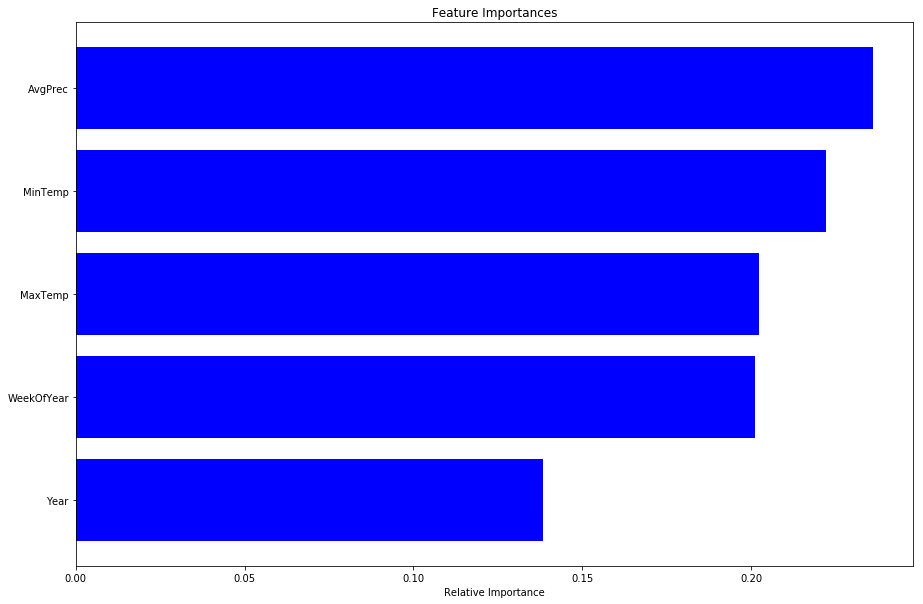

mae score: 30.095029568315287
Best Score: -4.42451904582806
Best params: {'bootstrap': True, 'max_features': 'log2', 'min_samples_split': 8, 'n_estimators': 10}
Loop:  1
--------------


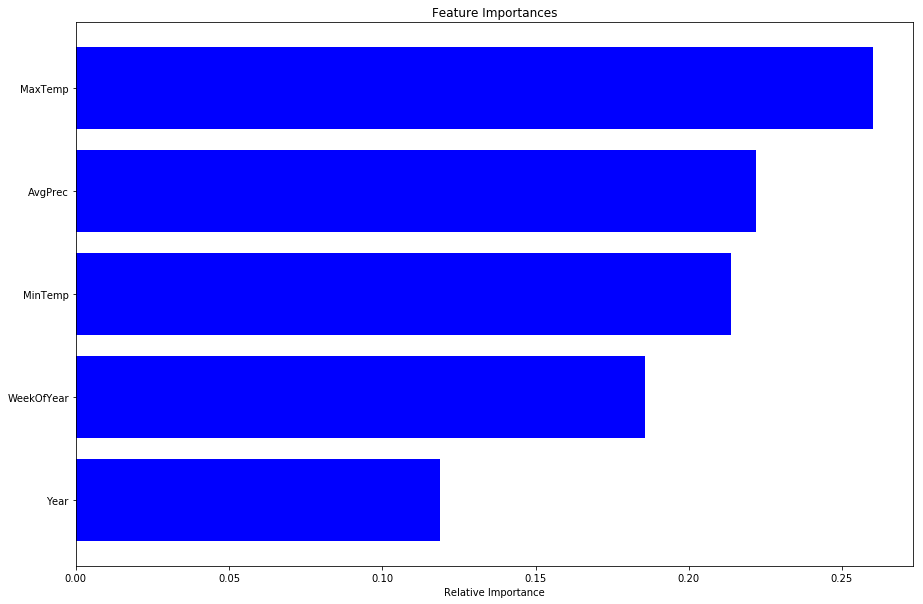

mae score: 30.378010204081637
Best Score: -4.705487394914551
Best params: {'bootstrap': True, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 10}
Loop:  2
--------------


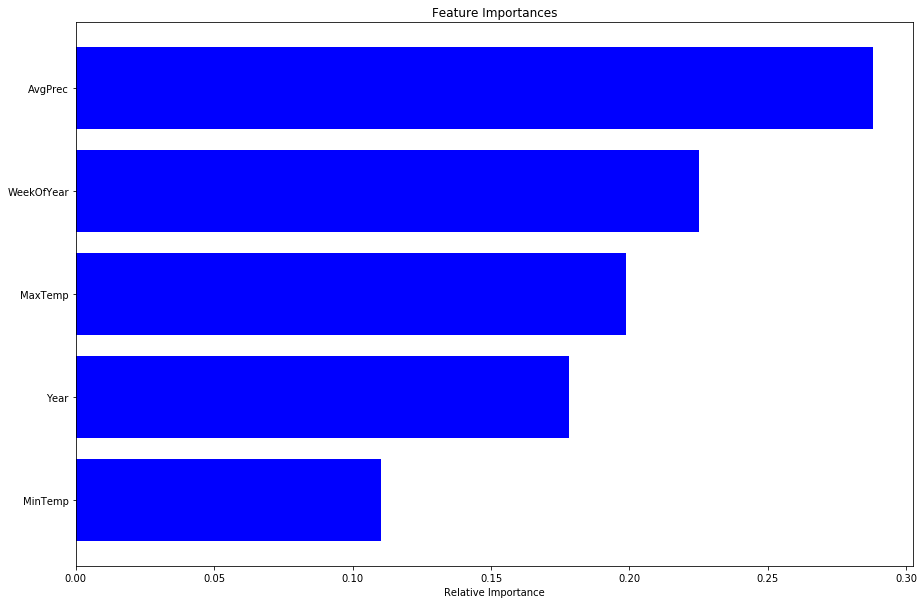

mae score: 31.687895753717186
Best Score: -4.319041090017082
Best params: {'bootstrap': True, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 10}


In [20]:
def Grid_Search_CV_RFR(X_train, y_train):
    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }
    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=10)
    grid.fit(X_train, y_train)
    return grid.best_score_ , grid.best_params_

def RFR(X_train, X_test, y_train, y_test, best_params):
    estimator = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    estimator.fit(X_train,y_train)
    features = predictors
    importances = estimator.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    y_predict = estimator.predict(X_test)
    print ("mae score:",mean_absolute_error(y_test,y_predict))
    return y_test,y_predict

for i in range(3):
    print ("Loop: " , i)
    print ("--------------")
    trainingSet, testSet = train_test_split(df, test_size=0.2,shuffle = False)
    # testSet
    X_test = testSet[predictors]
    Y_test = testSet['ILINumberOfCases']
    # trainSet
    X_train = trainingSet[predictors]
    Y_train = trainingSet['ILINumberOfCases']
    best_score, best_params = Grid_Search_CV_RFR(X_train, Y_train)
    Y_test , y_predict = RFR(X_train, X_test, Y_train, Y_test, best_params)
    print ("Best Score:" ,best_score)
    print ("Best params:",best_params)
